In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy

import torch_geometric as pygeom
import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.nn import global_max_pool
from torch_geometric.loader import DataLoader

import lightning.pytorch as pl

from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.colors as mcolors
from typing import Optional, Union, Any

## Datasets

### Node classification: BA-Shapes

In [288]:
trans = pygeom.transforms.Compose([T.Constant(), ])

node_dataset = ExplainerDataset(
    graph_generator=pygeom.datasets.graph_generator.BAGraph(num_nodes=300, num_edges=5),
    motif_generator='house',
    num_motifs=80,
    transform=trans,
)

In [289]:
node_dataset

ExplainerDataset(1, graph_generator=BAGraph(num_nodes=300, num_edges=5), motif_generator=HouseMotif(), num_motifs=80)

In [292]:
g = node_dataset[0]

In [293]:
train_idx, val_test_idx =  train_test_split(torch.arange(g.num_nodes), stratify=g.y, train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, stratify=g.y[val_test_idx], train_size=0.5)

### Graph classification: MUTAG

## GNN models

### Models Definition

In [303]:
class NodeGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for node classification.
    """
    def __init__(self, idcs):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(1, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, 4)
        self.train_idx, self.val_idx, _ = idcs

    def forward(self, data):
        out = F.relu(self.gc1(data.x, data.edge_index))
        out = F.relu(self.gc2(out, data.edge_index))
        out = F.relu(self.gc3(out, data.edge_index))
        return F.softmax(self.dense(out), dim=1)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, data, _):
        y_pred = self(data)
        loss = F.cross_entropy(y_pred[self.train_idx], data.y[self.train_idx])
        self.log('train_loss', loss, prog_bar=True, batch_size=1)
        return loss

    def validation_step(self, data, _):
        y_hat = self(data)
        self.log('val_accuracy', accuracy(y_hat[self.val_idx].argmax(dim=1), data.y[self.val_idx], task='multiclass', num_classes=4),
            prog_bar=True, batch_size=1)
        self.log('val_loss', F.cross_entropy(y_hat[self.val_idx], data.y[self.val_idx]),
            prog_bar=True, batch_size=1)

In [304]:
class GraphGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for graph classification.
    """
    def __init__(self, batch_size=8):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(10, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, 1)
        self.batch_size = batch_size

    def forward(self, batch):
        out = F.relu(self.gc1(batch.x, batch.edge_index))
        out = F.relu(self.gc2(out, batch.edge_index))
        out = F.relu(self.gc3(out, batch.edge_index))
        out = global_max_pool(out, batch.batch)
        return F.softmax(self.dense(out), dim=1)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, _):
        y_pred = self(batch)
        loss = F.binary_cross_entropy_with_logits(y_pred, batch.y.unsqueeze(1).float())
        self.log('train_loss', loss, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, _):
        y_hat = self.forward(batch)
        self.log('val_accuracy', pl.metrics.functional.accuracy(y_hat, batch.y.unsqueeze(1).float()),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)
        self.log('val_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)

### Models Training

In [305]:
gnn = NodeGNN((train_idx, val_idx, test_idx))

In [311]:
gnn(g)

tensor([[9.0193e-01, 6.1557e-02, 3.6493e-02, 2.1349e-05],
        [7.7703e-01, 2.1953e-01, 3.4356e-03, 1.2000e-08],
        [9.9933e-01, 9.0475e-05, 5.7464e-04, 4.8210e-06],
        ...,
        [1.1077e-01, 5.0045e-01, 3.8830e-01, 4.6687e-04],
        [2.4524e-01, 3.4546e-01, 4.0852e-01, 7.8689e-04],
        [2.1120e-01, 3.9240e-01, 3.9577e-01, 6.3567e-04]],
       grad_fn=<SoftmaxBackward0>)

In [307]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=5, mode='min')

In [308]:
trainer = pl.Trainer(max_epochs=1000, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [309]:
node_loader = pygeom.loader.DataLoader(node_dataset, batch_size=1, shuffle=True)

In [310]:
trainer.fit(gnn, node_loader, node_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 40    
1 | gc2   | GCNConv | 420   
2 | gc3   | GCNConv | 420   
3 | dense | Linear  | 84    
----------------------------------
964       Trainable params
0         Non-trainable params
964       Total params
0.004     Total estimated model params size (MB)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, v_num=22, train_loss=1.070, val_accuracy=0.743, val_loss=1.060] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s, v_num=22, train_loss=1.070, val_accuracy=0.743, val_loss=1.060]


## PGExplainer

In [ ]:
class PGExplainer(pl.LightningModule):
    
    def __init__(self, model, size_r=0.05, ent_r=1.0, max_epoch=30, temp=(5.0, 2.0), mode='node', *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        if mode == 'node':
            self.mlp = nn.Sequential(
                nn.Linear(60, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        elif mode == 'graph':
            self.mlp = nn.Sequential(
                nn.Linear(40, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        else:
            raise ValueError("mode must be either 'node' or 'graph'")
                
        
    def forward(self, *args: Any, **kwargs: Any) -> Any:
        pass
    
    def configure_optimizers(self) -> Any:
        pass
    
    def training_step(self, *args: Any, **kwargs: Any) -> Any:
        pass
    
    def validation_step(self, *args: Any, **kwargs: Any) -> Any:
        pass

In [108]:
class PGExplainer(ExplainerAlgorithm):
    
    
    coeffs = {
        'edge_size': 0.05,
        'edge_ent': 1.0,
        'temp': [5.0, 2.0],
        'bias': 0.0,
    }

    def __init__(self, epochs: int, lr: float = 3e-3, **kwargs):
        super().__init__()
        self.epochs = epochs
        self.lr = lr
        self.coeffs.update(kwargs)

        self.mlp = nn.Sequential(
            nn.Linear(-1, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        self.optimizer = torch.optim.Adam(self.mlp.parameters(), lr=lr)
        self._curr_epoch = -1


    def train(
        self,
        epoch: int,
        model: torch.nn.Module,
        x: torch.Tensor,
        edge_index: torch.Tensor,
        *,
        target: torch.Tensor,
        index: Optional[Union[int, torch.Tensor]] = None,
        **kwargs,
    ):
        r"""Trains the underlying explainer model.
        Needs to be called before being able to make predictions.

        Args:
            epoch (int): The current epoch of the training phase.
            model (torch.nn.Module): The model to explain.
            x (torch.Tensor): The input node features of a
                homogeneous graph.
            edge_index (torch.Tensor): The input edge indices of a homogeneous
                graph.
            target (torch.Tensor): The target of the model.
            index (int or torch.Tensor, optional): The index of the model
                output to explain. Needs to be a single index.
                (default: :obj:`None`)
            **kwargs (optional): Additional keyword arguments passed to
                :obj:`model`.
        """

        z = pygeom.utils.get_embeddings(model, x, edge_index, **kwargs)[-1]

        self.optimizer.zero_grad()
        temperature = self._get_temperature(epoch)

        inputs = self._get_inputs(z, edge_index, index)
        logits = self.mlp(inputs).view(-1)
        edge_mask = self._concrete_sample(logits, temperature)
        set_masks(model, edge_mask, edge_index, apply_sigmoid=True)

        if self.model_config.task_level == ModelTaskLevel.node:
            _, hard_edge_mask = self._get_hard_masks(model, index, edge_index,
                                                     num_nodes=x.size(0))
            edge_mask = edge_mask[hard_edge_mask]

        y_hat, y = model(x, edge_index, **kwargs), target

        if index is not None:
            y_hat, y = y_hat[index], y[index]

        loss = self._loss(y_hat, y, edge_mask)
        loss.backward()
        self.optimizer.step()

        clear_masks(model)
        self._curr_epoch = epoch

        return float(loss)

    def forward(
        self,
        model: torch.nn.Module,
        x: Tensor,
        edge_index: Tensor,
        *,
        target: Tensor,
        index: Optional[Union[int, Tensor]] = None,
        **kwargs,
    ) -> Explanation:
        if isinstance(x, dict) or isinstance(edge_index, dict):
            raise ValueError(f"Heterogeneous graphs not yet supported in "
                             f"'{self.__class__.__name__}'")

        if self._curr_epoch < self.epochs - 1:  # Safety check:
            raise ValueError(f"'{self.__class__.__name__}' is not yet fully "
                             f"trained (got {self._curr_epoch + 1} epochs "
                             f"from {self.epochs} epochs). Please first train "
                             f"the underlying explainer model by running "
                             f"`explainer.algorithm.train(...)`.")

        hard_edge_mask = None
        if self.model_config.task_level == ModelTaskLevel.node:
            if index is None:
                raise ValueError(f"The 'index' argument needs to be provided "
                                 f"in '{self.__class__.__name__}' for "
                                 f"node-level explanations")
            if isinstance(index, Tensor) and index.numel() > 1:
                raise ValueError(f"Only scalars are supported for the 'index' "
                                 f"argument in '{self.__class__.__name__}'")

            # We need to compute hard masks to properly clean up edges and
            # nodes attributions not involved during message passing:
            _, hard_edge_mask = self._get_hard_masks(model, index, edge_index,
                                                     num_nodes=x.size(0))

        z = get_embeddings(model, x, edge_index, **kwargs)[-1]

        inputs = self._get_inputs(z, edge_index, index)
        logits = self.mlp(inputs).view(-1)

        edge_mask = self._post_process_mask(logits, hard_edge_mask,
                                            apply_sigmoid=True)

        return Explanation(edge_mask=edge_mask)

    def supports(self) -> bool:
        explanation_type = self.explainer_config.explanation_type
        if explanation_type != ExplanationType.phenomenon:
            logging.error(f"'{self.__class__.__name__}' only supports "
                          f"phenomenon explanations "
                          f"got (`explanation_type={explanation_type.value}`)")
            return False

        task_level = self.model_config.task_level
        if task_level not in {ModelTaskLevel.node, ModelTaskLevel.graph}:
            logging.error(f"'{self.__class__.__name__}' only supports "
                          f"node-level or graph-level explanations "
                          f"got (`task_level={task_level.value}`)")
            return False

        node_mask_type = self.explainer_config.node_mask_type
        if node_mask_type is not None:
            logging.error(f"'{self.__class__.__name__}' does not support "
                          f"explaining input node features "
                          f"got (`node_mask_type={node_mask_type.value}`)")
            return False

        return True

    ###########################################################################

    def _get_inputs(self, embedding: Tensor, edge_index: Tensor,
                    index: Optional[int] = None) -> Tensor:
        zs = [embedding[edge_index[0]], embedding[edge_index[1]]]
        if self.model_config.task_level == ModelTaskLevel.node:
            assert index is not None
            zs.append(embedding[index].view(1, -1).repeat(zs[0].size(0), 1))
        return torch.cat(zs, dim=-1)

    def _get_temperature(self, epoch: int) -> float:
        temp = self.coeffs['temp']
        return temp[0] * pow(temp[1] / temp[0], epoch / self.epochs)

    def _concrete_sample(self, logits: Tensor,
                         temperature: float = 1.0) -> Tensor:
        bias = self.coeffs['bias']
        eps = (1 - 2 * bias) * torch.rand_like(logits) + bias
        return (eps.log() - (1 - eps).log() + logits) / temperature

    def _loss(self, y_hat: Tensor, y: Tensor, edge_mask: Tensor) -> Tensor:
        if self.model_config.mode == ModelMode.binary_classification:
            loss = self._loss_binary_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.multiclass_classification:
            loss = self._loss_multiclass_classification(y_hat, y)
        elif self.model_config.mode == ModelMode.regression:
            loss = self._loss_regression(y_hat, y)

        # Regularization loss:
        mask = edge_mask.sigmoid()
        size_loss = mask.sum() * self.coeffs['edge_size']
        mask = 0.99 * mask + 0.005
        mask_ent = -mask * mask.log() - (1 - mask) * (1 - mask).log()
        mask_ent_loss = mask_ent.mean() * self.coeffs['edge_ent']

        return loss + size_loss + mask_ent_loss
        
        
    
            

NameError: name 'Tensor' is not defined

## Collect dataset

In [35]:
dataset = pygeom.datasets.TUDataset('./mutag', 'MUTAG', cleaned=True)

In [36]:
g = dataset[0]
print("graph shape:", g.x.shape)
print("node features:", g.x[0])
print("graph classification:", g.y)
print("edge index:", g.edge_index)

graph shape: torch.Size([17, 7])
node features: tensor([1., 0., 0., 0., 0., 0., 0.])
graph classification: tensor([1])
edge index: tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])


In [83]:
print(g)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


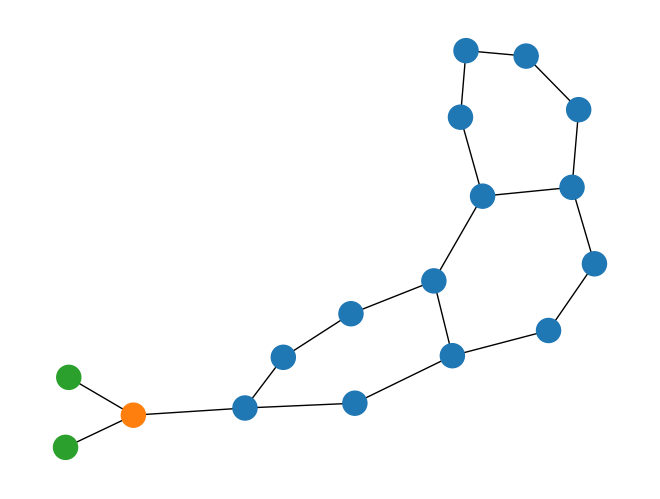

In [60]:
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
            node_color=[colors[i.item()] for i in g.x.argmax(dim=1)])

In [88]:
sub_gs = []
for n in range(g.x.shape[0]):
    idcs, _, _, edges_mask = pygeom.utils.k_hop_subgraph(n, 3, g.edge_index)
    subg = g.clone()
    subg.edge_index = subg.edge_index[:, edges_mask]
    subg.edge_attr = subg.edge_attr[edges_mask]
    sub_gs.append(subg)

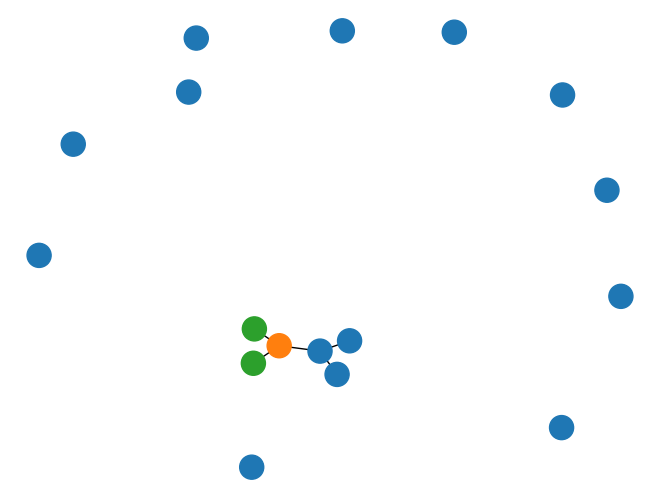

In [106]:
i = 16
nx.draw(pygeom.utils.to_networkx(sub_gs[i], to_undirected=True),
        node_color=[colors[i.item()] for i in sub_gs[i].x.argmax(dim=1)])